<a href="https://colab.research.google.com/github/Namiiii-sys/Success-Drivers-for-Github-Repo-Prediction-Model/blob/main/Identifying_Success_Drivers_for_Trending_Open_Source_Projects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================================
#  GITHUB TRENDING DATA ANALYSIS & GROWTH PREDICTION
# ==========================================================
# Purpose : Predict the growth potential of GitHub repositories and identify what makes certain open-source repositories go viral
# Dataset : Weekly top 100 trending repositories per language
# Output: A model that predicts whether a repo is likely to become “viral” and a list of top 5 factors influencing that popularity.
# ==========================================================

In [ ]:
# -------------------------------
# Importing Dependencies
# -------------------------------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re
from sklearn.preprocessing import LabelEncoder

In [ ]:
sb.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (10, 5)

In [ ]:
df = pd.read_csv("final_dirty_with_duplicates.csv")

In [ ]:
df.shape
df.head()

,language,name,full_name,url,description,stars,forks,watchers,open_issues,owner,created_at,updated_at
0,cpp,swoole-src,swoole/swoole-src,https://github.com/swoole/swoole-src,🚀 Coroutine-based concurrency library for PHP,19093.452881,3211.865748,18304.121460,77.918565,swoole,2012-07-21T13:49:59Z,2025-11-03T02:54:19Z
1,Java,druid,apache/druid,https://github.com/apache/druid,Apache Druid: A High Performance Real-Time Ana...,14259.614623,3888.290852,14154.807976,732.258573,Apache,2012-10-23T19:08:07Z,2025-11-01T20:58:26Z
2,python,yt-dlp,Yt-Dlp/Yt-Dlp,Https://Github.Com/Yt-Dlp/Yt-Dlp,A feature-rich command-line audio/video downlo...,129885.605276,11251.372535,140167.406078,2197.021230,yt-dlp,2020-10-26T04:22:55Z,2025-11-03T08:13:29Z
3,python,odoo,odoo/odoo,https://github.com/odoo/odoo,Odoo. Open Source Apps To Grow Your Business.,47807.237550,29345.420235,46272.830771,9026.624810,Odoo,2014-05-13T15:38:58Z,2025-11-03T08:24:50Z
4,rust,wasmer,wasmerio/wasmer,https://github.com/wasmerio/wasmer,"🚀 Fast, secure, lightweight containers based o...",20827.631478,911.638223,19733.997456,187.318242,wasmerio,2018-10-11t10:15:53z,2025-11-02T16:49:21Z


In [ ]:
# -------------------------------
# STEP 3: Basic Cleaning
# -------------------------------

In [ ]:
df.isnull().sum()


,0
language,0
name,0
full_name,0
url,0
description,0
stars,41
forks,24
watchers,25
open_issues,22
owner,0


In [ ]:
df.duplicated().sum()

np.int64(17)

In [ ]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 516
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   language     500 non-null    object 
 1   name         500 non-null    object 
 2   full_name    500 non-null    object 
 3   url          500 non-null    object 
 4   description  500 non-null    object 
 5   stars        460 non-null    float64
 6   forks        478 non-null    float64
 7   watchers     475 non-null    float64
 8   open_issues  480 non-null    float64
 9   owner        500 non-null    object 
 10  created_at   500 non-null    object 
 11  updated_at   500 non-null    object 
dtypes: float64(4), object(8)
memory usage: 50.8+ KB


In [ ]:
df['description'].fillna('',inplace=True)

/tmp/ipython-input-2370492763.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['description'].fillna('',inplace=True)


In [ ]:
cols_to_drop = ['url', 'full_name', 'owner']
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)


In [ ]:
num_cols = ['stars', 'forks', 'watchers', 'open_issues']
for col in num_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)
    print(f"Filled missing values in '{col}' with median = {median_val:.2f}")


Filled missing values in 'stars' with median = 29439.01
Filled missing values in 'forks' with median = 3545.32
Filled missing values in 'watchers' with median = 29069.91
Filled missing values in 'open_issues' with median = 352.93


In [ ]:
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['updated_at'] = pd.to_datetime(df['updated_at'], errors='coerce')
df['created_at'] = df['created_at'].dt.tz_localize(None)
df['updated_at'] = df['updated_at'].dt.tz_localize(None)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 516
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   language     500 non-null    object        
 1   name         500 non-null    object        
 2   description  500 non-null    object        
 3   stars        500 non-null    float64       
 4   forks        500 non-null    float64       
 5   watchers     500 non-null    float64       
 6   open_issues  500 non-null    float64       
 7   created_at   383 non-null    datetime64[ns]
 8   updated_at   378 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(4), object(3)
memory usage: 39.1+ KB


In [ ]:
corr_matrix = df[num_cols].corr()

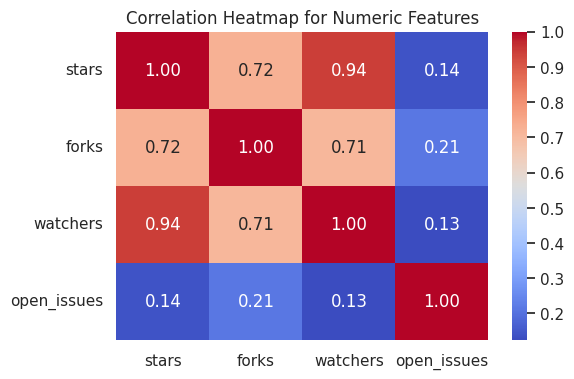

                stars     forks  watchers  open_issues
stars        1.000000  0.723881  0.943671     0.142750
forks        0.723881  1.000000  0.710591     0.213334
watchers     0.943671  0.710591  1.000000     0.125874
open_issues  0.142750  0.213334  0.125874     1.000000


In [ ]:
plt.figure(figsize=(6,4))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for Numeric Features")
plt.show()

print(corr_matrix)

In [ ]:
# -------------------------------------------------------------
#  FEATURE ENGINEERING
# -------------------------------------------------------------

In [ ]:
#1. Age of Repository (in days)
df['repo_age_days'] = (pd.Timestamp.now(tz=None) - df['created_at']).dt.days
df['stars_per_day'] = df['stars'] / df['repo_age_days']

#2. Update Recency (how recently updated, in days)
df['days_since_update'] = (pd.Timestamp.now(tz=None) - df['updated_at']).dt.days

#3. Engagement Ratios
df['stars_per_fork'] = df['stars'] / (df['forks'] + 1)
df['issues_per_star'] = df['open_issues'] / (df['stars'] + 1)

#4. Popularity Intensity (combined metric)
df['popularity_intensity'] = (
    df['stars'] * 0.6 + df['forks'] * 0.3 + df['watchers'] * 0.1
)
#5. Description Length (proxy for documentation quality)
df['desc_length'] = df['description'].astype(str).apply(len)
df['desc_word_count'] = df['description'].astype(str).apply(lambda x: len(x.split()))

# classifying repositories into popularity levels
df['popularity_level'] = pd.qcut(df['stars'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

In [ ]:
new_num_cols = ['stars', 'forks', 'watchers', 'open_issues', 'repo_age_days',
                    'days_since_update', 'stars_per_fork', 'issues_per_star',
                    'popularity_intensity', 'desc_length', 'desc_word_count']

df[new_num_cols] = df[new_num_cols].fillna(df[new_num_cols].median())


df['created_at'] = df['created_at'].fillna(df['created_at'].median())
df['updated_at'] = df['updated_at'].fillna(df['updated_at'].median())


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['language'] = df['language'].astype(str).str.strip().str.lower()
df['language_encoded'] = le.fit_transform(df['language'])

lang_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Language Encoding Map:")
for k, v in lang_mapping.items():
    print(f"{k} → {v}")

print("\nUnique Encoded Values:", df['language_encoded'].unique())

Language Encoding Map:
cpp → 0
java → 1
javascript → 2
python → 3
rust → 4

Unique Encoded Values: [0 1 3 4 2]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 516
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   language              500 non-null    object        
 1   name                  500 non-null    object        
 2   description           500 non-null    object        
 3   stars                 500 non-null    float64       
 4   forks                 500 non-null    float64       
 5   watchers              500 non-null    float64       
 6   open_issues           500 non-null    float64       
 7   created_at            500 non-null    datetime64[ns]
 8   updated_at            500 non-null    datetime64[ns]
 9   repo_age_days         500 non-null    float64       
 10  stars_per_day         383 non-null    float64       
 11  days_since_update     500 non-null    float64       
 12  stars_per_fork        500 non-null    float64       
 13  issues_per_star       500

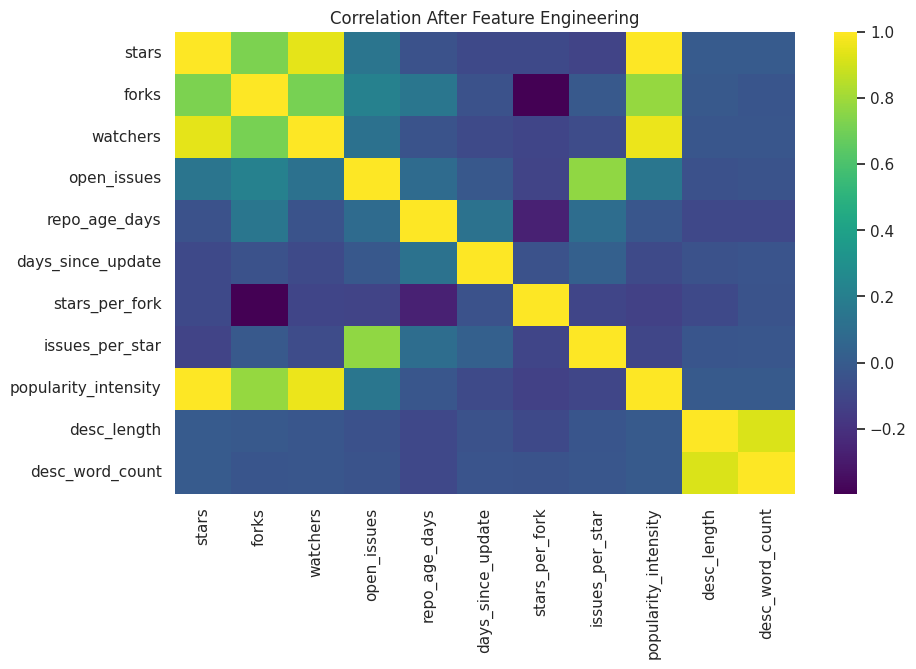

In [ ]:
plt.figure(figsize=(10,6))
sb.heatmap(df[new_num_cols].corr(), annot=False, cmap='viridis')
plt.title("Correlation After Feature Engineering")
plt.show()

In [ ]:
# ---------------------------------------
#  TEXT FEATURES (buzzwords)
# ---------------------------------------

In [ ]:
df['description'] = df['description'].fillna('').astype(str)

ai_keywords = r'\b(?:ai|ml|machine learning|deep learning|neural network|nlp|language model|llm|gpt)\b'
df['has_ai'] = df['description'].str.contains(ai_keywords, flags=re.IGNORECASE, regex=True).astype(int)

tool_keywords = r'\b(?:tool|library|framework|api|sdk|package|module)\b'
df['has_tool'] = df['description'].str.contains(tool_keywords, flags=re.IGNORECASE, regex=True).astype(int)

print("\nAI-related repos:", df['has_ai'].sum())
print("Tool-related repos:", df['has_tool'].sum())



AI-related repos: 60
Tool-related repos: 119


In [ ]:
# ---------------------------------------
# 4) Creating target (growth_category) — based on stars_per_day
# ---------------------------------------

In [ ]:
# Computing quantile thresholds
q_low = df['stars_per_day'].quantile(0.33)
q_high = df['stars_per_day'].quantile(0.67)

def growth_cat(x):
    if x <= q_low:
        return 'Low'
    elif x <= q_high:
        return 'Medium'
    else:
        return 'High'

df['growth_category'] = df['stars_per_day'].apply(growth_cat)
df['growth_encoded'] = pd.Categorical(df['growth_category']).codes


In [ ]:
df.head()

,language,name,description,stars,forks,watchers,open_issues,created_at,updated_at,repo_age_days,...,issues_per_star,popularity_intensity,desc_length,desc_word_count,popularity_level,language_encoded,has_ai,has_tool,growth_category,growth_encoded
0,cpp,swoole-src,🚀 Coroutine-based concurrency library for PHP,19093.452881,3211.865748,18304.121460,77.918565,2012-07-21 13:49:59,2025-11-03 02:54:19,4857.0,...,0.004081,14250.043599,45,6,Low,0,0,1,Low,1
1,java,druid,Apache Druid: A High Performance Real-Time Ana...,14259.614623,3888.290852,14154.807976,732.258573,2012-10-23 19:08:07,2025-11-01 20:58:26,4762.0,...,0.051348,11137.736827,62,8,Low,1,0,0,Low,1
2,python,yt-dlp,A feature-rich command-line audio/video downlo...,129885.605276,11251.372535,140167.406078,2197.021230,2020-10-26 04:22:55,2025-11-03 08:13:29,1838.0,...,0.016915,95323.515534,50,5,Very High,3,0,0,High,0
3,python,odoo,Odoo. Open Source Apps To Grow Your Business.,47807.237550,29345.420235,46272.830771,9026.624810,2014-05-13 15:38:58,2025-11-03 08:24:50,4195.0,...,0.188809,42115.251678,45,8,Very High,3,0,0,Medium,2
4,rust,wasmer,"🚀 Fast, secure, lightweight containers based o...",20827.631478,911.638223,19733.997456,187.318242,2017-08-11 18:38:22,2025-11-02 16:49:21,3009.0,...,0.008993,14743.470099,59,8,Low,4,0,0,High,0


/tmp/ipython-input-3909317230.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x='growth_category', data=df, palette='viridis')


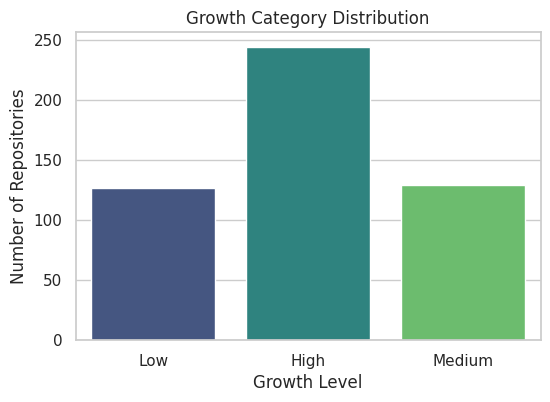

,count
growth_category,
High,244
Medium,129
Low,127


In [ ]:
plt.figure(figsize=(6,4))
sb.countplot(x='growth_category', data=df, palette='viridis')
plt.title("Growth Category Distribution")
plt.xlabel("Growth Level")
plt.ylabel("Number of Repositories")
plt.show()

df['growth_category'].value_counts()


In [ ]:
# ------------------------------------------
# 4) feature Selection and train-test split
# ------------------------------------------

In [ ]:
feature_cols = ['stars', 'forks', 'watchers', 'open_issues','repo_age_days', 'days_since_update','stars_per_fork', 'issues_per_star', 'popularity_intensity','desc_length', 'desc_word_count','has_ai',
 'has_tool','language_encoded']

target_col = 'growth_encoded'

X = df[feature_cols]
Y = df[target_col]

print("Feature matrix shape:", X.shape)
print("Target shape:", Y.shape)


Feature matrix shape: (500, 14)
Target shape: (500,)


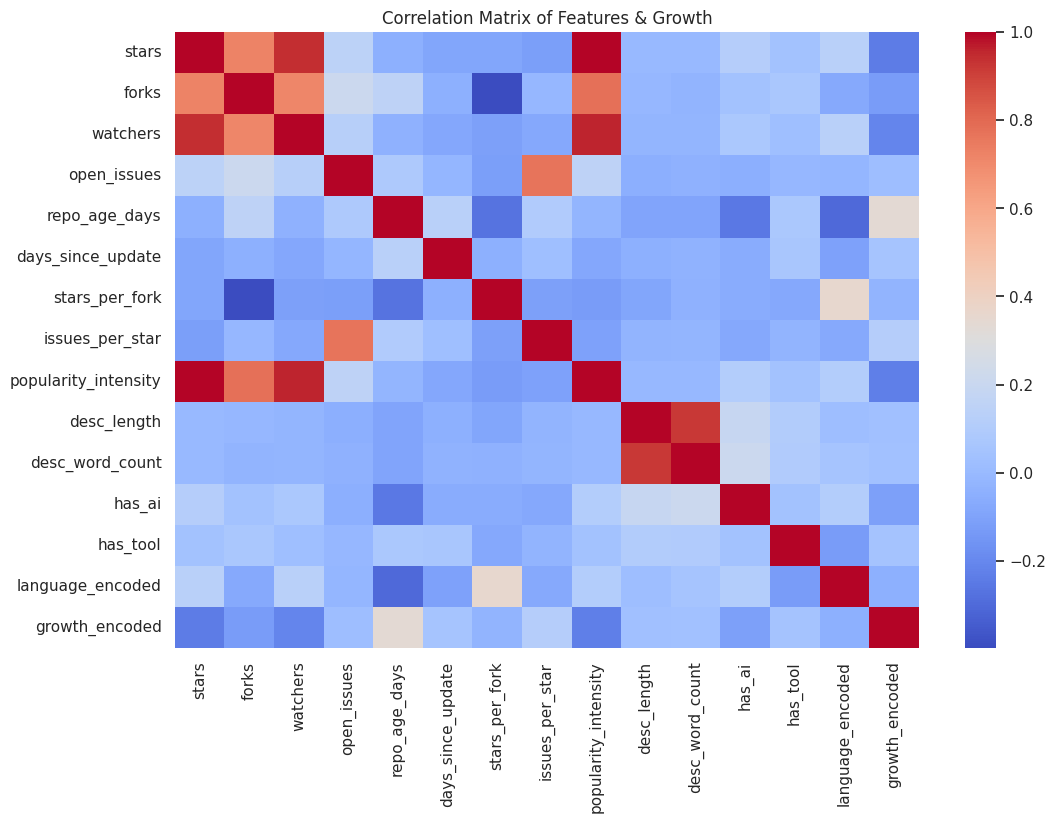

In [ ]:
corr = df[feature_cols + ['growth_encoded']].corr()

plt.figure(figsize=(12,8))
sb.heatmap(corr, cmap='coolwarm', annot=False, cbar=True)
plt.title("Correlation Matrix of Features & Growth")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

print(f"Training size: {X_train.shape[0]}")
print(f"Testing size: {X_test.shape[0]}")


Training size: 400
Testing size: 100


In [ ]:
# ---------------------------------------
#  Import Model Libraries
# ---------------------------------------

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


models = {
    "XGboost": XGBClassifier(random_state=42, max_depth=5),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=200),
    "Naive Bayes": GaussianNB()
}

results = {}

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc

    print(f"\n{'='*40}")
    print(f"Model: {name}")
    print(f"Accuracy: {acc*100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, preds))



Model: XGboost
Accuracy: 95.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        49
           1       0.96      0.92      0.94        25
           2       0.92      0.88      0.90        26

    accuracy                           0.95       100
   macro avg       0.95      0.93      0.94       100
weighted avg       0.95      0.95      0.95       100


Model: Random Forest
Accuracy: 85.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90        49
           1       0.91      0.84      0.88        25
           2       0.84      0.62      0.71        26

    accuracy                           0.85       100
   macro avg       0.86      0.81      0.83       100
weighted avg       0.85      0.85      0.84       100


Model: Naive Bayes
Accuracy: 57.00%

Classification Report:
              precision    recall  f1-score   support

  

/tmp/ipython-input-3128088010.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=list(results.keys()), y=list(results.values()), palette="coolwarm")


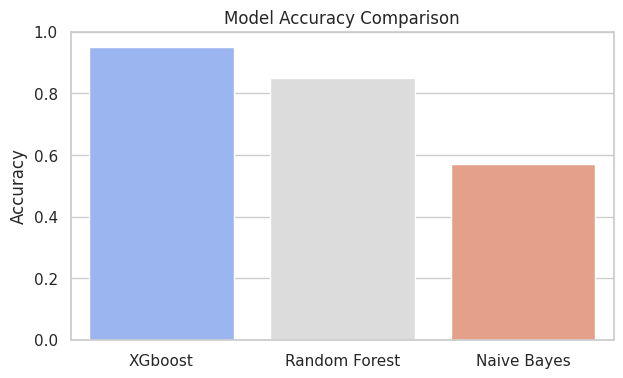

In [ ]:
plt.figure(figsize=(7,4))
sb.barplot(x=list(results.keys()), y=list(results.values()), palette="coolwarm")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


/tmp/ipython-input-2851652608.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=importances[indices][:5], y=top_features, palette='viridis')


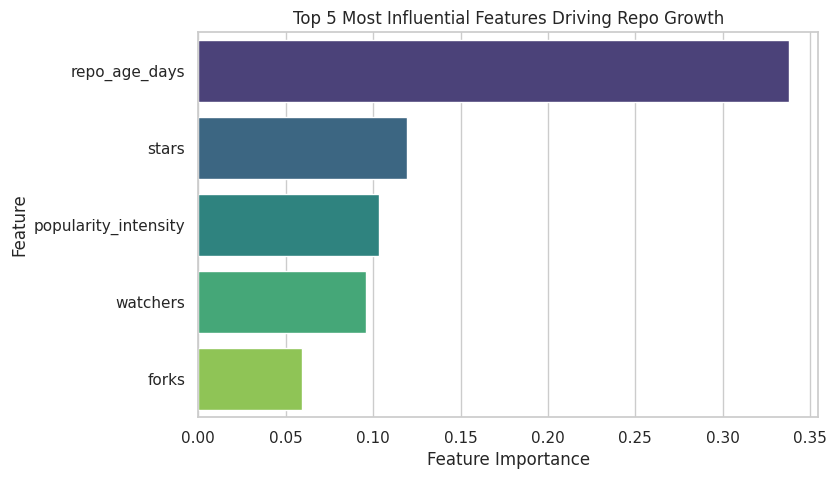


 Top 5 Features Influencing Repo Growth: 
repo_age_days: 0.3378
stars: 0.1195
popularity_intensity: 0.1032
watchers: 0.0959
forks: 0.0596


In [ ]:
best_model = models["Random Forest"]

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = np.array(feature_cols)[indices][:5]

plt.figure(figsize=(8,5))
sb.barplot(x=importances[indices][:5], y=top_features, palette='viridis')
plt.title("Top 5 Most Influential Features Driving Repo Growth")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

print("\n Top 5 Features Influencing Repo Growth: ")
for f, imp in zip(top_features, importances[indices][:5]):
    print(f"{f}: {imp:.4f}")



=== Time-Series Growth Analysis ===


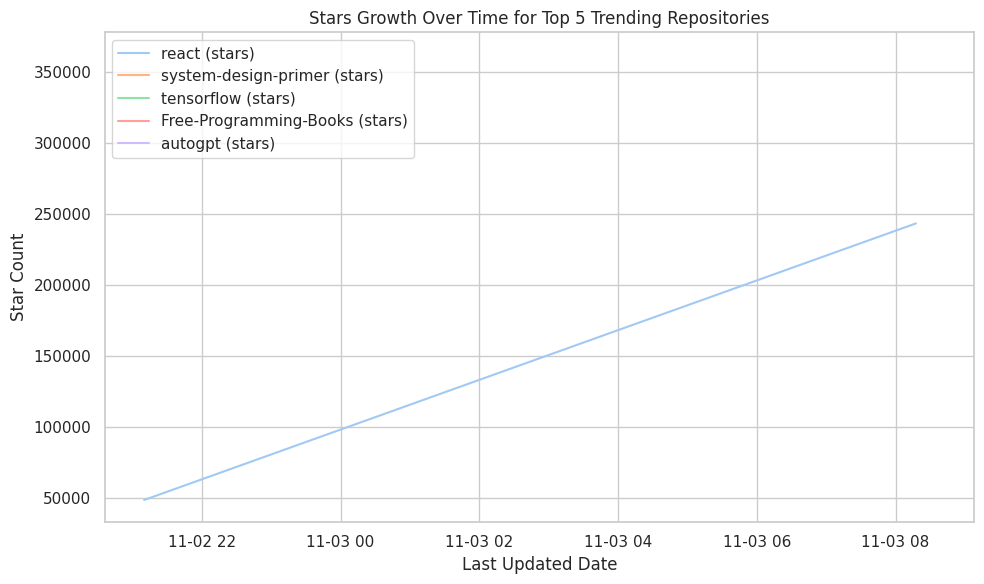

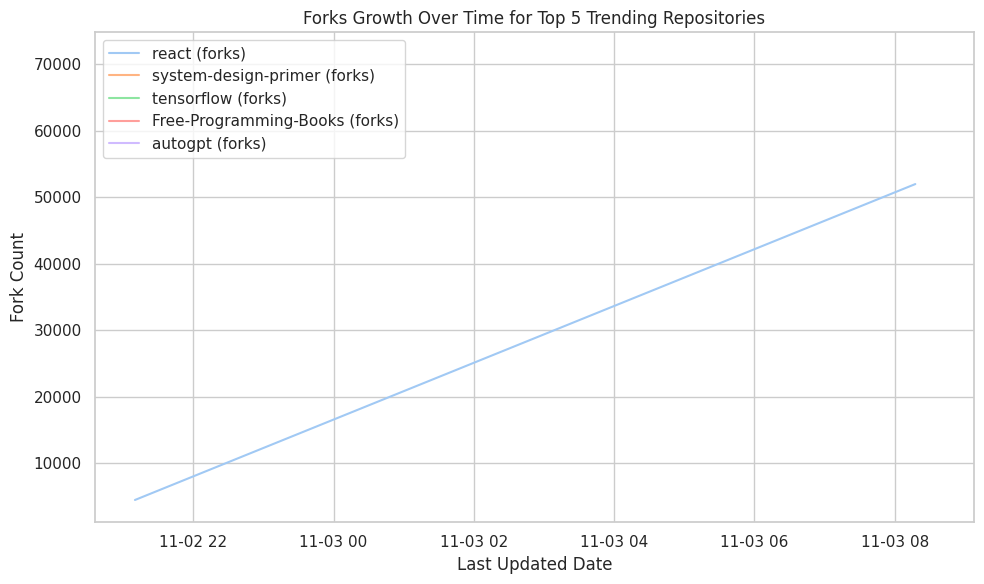

/tmp/ipython-input-774526255.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=lang_trend.values, y=lang_trend.index, palette="coolwarm")


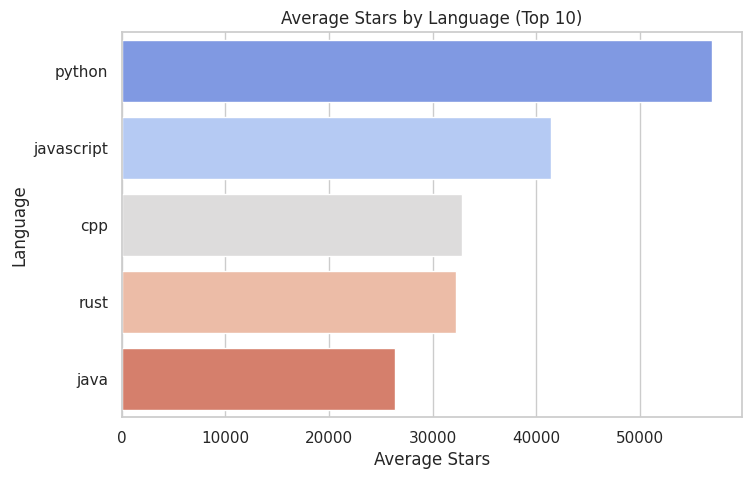

In [ ]:
# ==========================================================
#  TIME-SERIES GROWTH ANALYSIS
# ==========================================================
# This section visualizes how stars and forks evolve over time
# for the most popular repositories.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

print("\n=== Time-Series Growth Analysis ===")

df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['updated_at'] = pd.to_datetime(df['updated_at'], errors='coerce')

# Top 5 most starred repositories
if 'name' in df.columns:
    top_repos = df.groupby('name')['stars'].max().nlargest(5).index
else:
    print("Column 'name' not found; skipping repo name grouping.")
    top_repos = df.nlargest(5, 'stars').index

# Data for top repos only
df_top = df[df['name'].isin(top_repos)].copy()

# Sort by creation or update date
df_top.sort_values(by='updated_at', inplace=True)

# Plot stars and forks trend
plt.figure(figsize=(10, 6))
for repo in df_top['name'].unique():
    subset = df_top[df_top['name'] == repo]
    plt.plot(subset['updated_at'], subset['stars'], label=f"{repo} (stars)")

plt.title("Stars Growth Over Time for Top 5 Trending Repositories")
plt.xlabel("Last Updated Date")
plt.ylabel("Star Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Forks over time
plt.figure(figsize=(10, 6))
for repo in df_top['name'].unique():
    subset = df_top[df_top['name'] == repo]
    plt.plot(subset['updated_at'], subset['forks'], label=f"{repo} (forks)")

plt.title("Forks Growth Over Time for Top 5 Trending Repositories")
plt.xlabel("Last Updated Date")
plt.ylabel("Fork Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Language-level trend
lang_trend = (
    df.groupby(['language'])['stars']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 5))
sb.barplot(x=lang_trend.values, y=lang_trend.index, palette="coolwarm")
plt.title("Average Stars by Language (Top 10)")
plt.xlabel("Average Stars")
plt.ylabel("Language")
plt.show()


In [ ]:
df['growth_category'].value_counts(normalize=True)

,proportion
growth_category,
High,0.488
Medium,0.258
Low,0.254


In [ ]:
RandomForestClassifier(class_weight='balanced', random_state=42)

RandomForestClassifier(class_weight='balanced', random_state=42)


Repositories per language:
 language
cpp           100
java          100
python        100
rust          100
javascript    100
Name: count, dtype: int64

Training samples: 400
Testing samples: 100


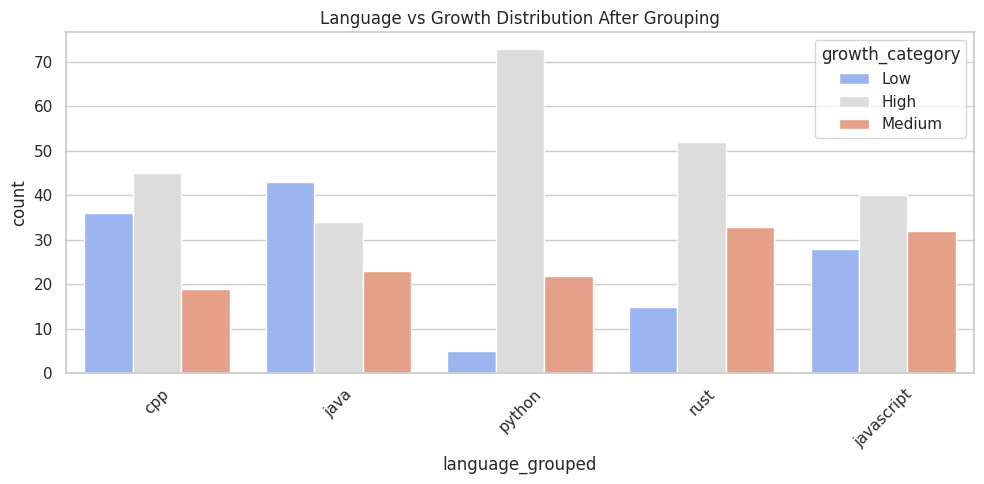

In [ ]:
# ===========================================
#  FIXING LANGUAGE / TEMPORAL BIAS (CLEAN VERSION)
# ===========================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

# Make sure X and df are proper copies
X = df[feature_cols].copy()
Y = df[target_col].copy()

# ---- 1. Normalize temporal effects ----
df['stars_norm'] = df['stars'] / (df['repo_age_days'] + 1)
df['forks_norm'] = df['forks'] / (df['repo_age_days'] + 1)
df['watchers_norm'] = df['watchers'] / (df['repo_age_days'] + 1)

# Update normalized values in X safely
X.loc[:, 'stars'] = df['stars_norm']
X.loc[:, 'forks'] = df['forks_norm']
X.loc[:, 'watchers'] = df['watchers_norm']

# ---- 2. Handle language/topic imbalance ----
lang_counts = df['language'].value_counts()
print("\nRepositories per language:\n", lang_counts)

# Drop or group rare languages (<5% of dataset)
min_count = int(0.05 * len(df))
rare_langs = lang_counts[lang_counts < min_count].index
df['language_grouped'] = df['language'].apply(lambda x: 'other' if x in rare_langs else x)

# Encode grouped language
le = LabelEncoder()
df['language_encoded'] = le.fit_transform(df['language_grouped'])
X.loc[:, 'language_encoded'] = df['language_encoded']

# ---- 3. Stratified train-test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# ---- 4. Visualize distribution (optional) ----
plt.figure(figsize=(10,5))
sb.countplot(x='language_grouped', hue='growth_category', data=df, palette='coolwarm')
plt.title("Language vs Growth Distribution After Grouping")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


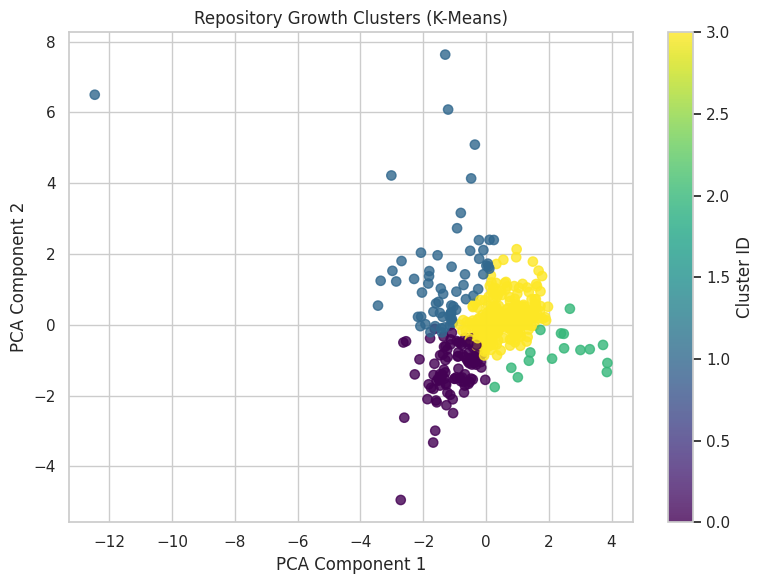


=== Cluster Characteristics ===


,stars_per_day,days_since_update,stars_per_fork,repo_age_days,popularity_intensity,stars_per_day
growth_cluster,,,,,,
0,21.00,4.00,26.44,2119.32,21362.91,21.00
1,97.97,4.00,8.22,1668.19,66588.40,97.97
2,5.41,5.56,9.63,4012.00,15639.44,5.41
3,9.17,4.00,7.50,3578.71,23805.90,9.17


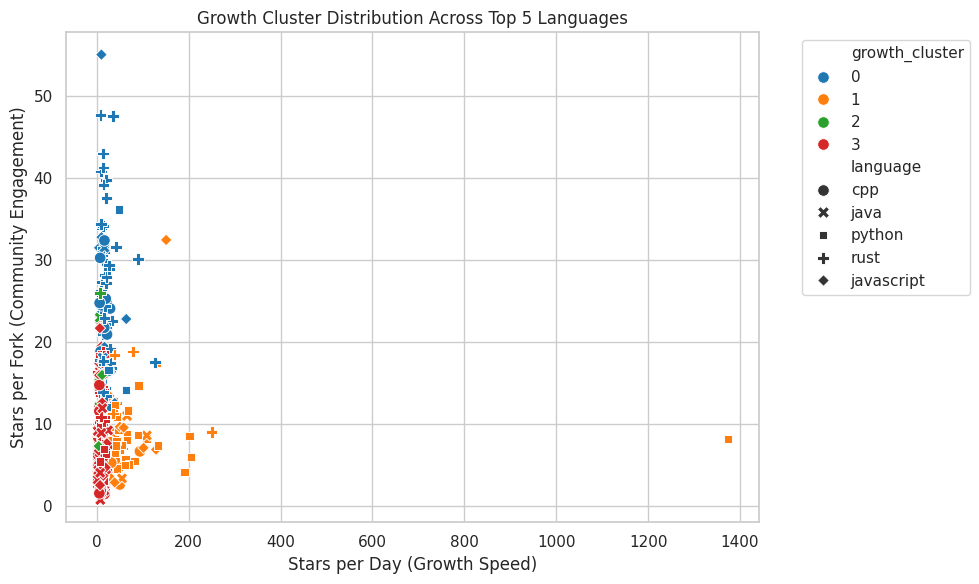

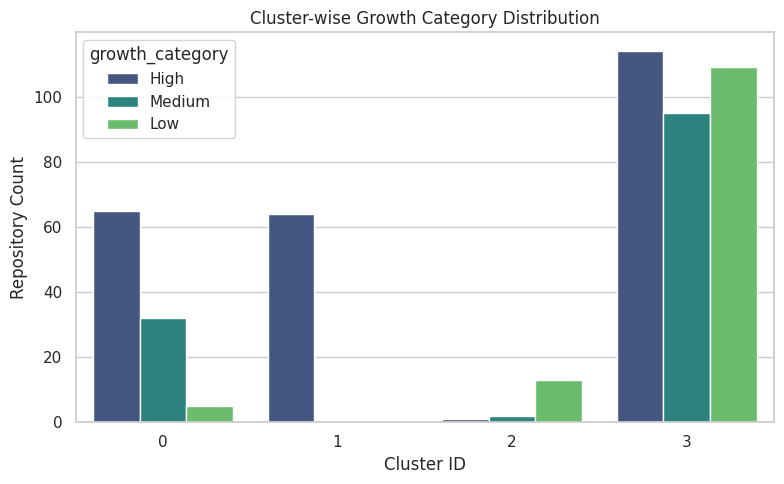


=== Cluster–Growth Category Cross-Tab ===


growth_category,High,Low,Medium
growth_cluster,,,
0,0.64,0.05,0.31
1,1.00,0.00,0.00
2,0.06,0.81,0.12
3,0.36,0.34,0.30



 SUMMARY & CONCLUSIONS:
• Cluster 0:  Moderate Growth with Mixed Engagement (Avg Stars/Day = 21.00, Days Since Update = 4.0, Popularity Intensity = 21362.9)
• Cluster 1:  Moderate Growth with Mixed Engagement (Avg Stars/Day = 97.97, Days Since Update = 4.0, Popularity Intensity = 66588.4)
• Cluster 2:  Stagnant or Inactive Repos (Avg Stars/Day = 5.41, Days Since Update = 5.6, Popularity Intensity = 15639.4)
• Cluster 3:  Moderate Growth with Mixed Engagement (Avg Stars/Day = 9.17, Days Since Update = 4.0, Popularity Intensity = 23805.9)

 Key Takeaways:
1. Clusters reveal distinct growth behaviors — some fast-growing and active, others stagnant.
2. Languages like Python and JavaScript show different clustering patterns based on engagement metrics.
3. High-growth clusters usually have frequent updates, high stars_per_day, and strong popularity intensity.
4. These clusters can guide creators on strategies — e.g., regular updates and community engagement foster faster trending.


In [ ]:
# ==============================================================
#   CLUSTERING ANALYSIS FOR GROWTH PATTERNS IN OPEN-SOURCE REPOS
# ==============================================================

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np

# -----------------------------
# 1️  GROWTH-BEHAVIOR CLUSTERING (K-MEANS)
# -----------------------------

cluster_features = ['stars_per_day', 'days_since_update', 'stars_per_fork',
                    'repo_age_days', 'popularity_intensity']

X_cluster = df[cluster_features].fillna(df[cluster_features].median())
X_scaled = StandardScaler().fit_transform(X_cluster)

# K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['growth_cluster'] = kmeans.fit_predict(X_scaled)

# 2D visualization using PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1],
            c=df['growth_cluster'], cmap='viridis', s=45, alpha=0.8)
plt.title("Repository Growth Clusters (K-Means)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster ID')
plt.tight_layout()
plt.show()

# Cluster summary
cluster_summary = df.groupby('growth_cluster')[cluster_features + ['stars_per_day']].mean().round(2)
print("\n=== Cluster Characteristics ===")
display(cluster_summary)


# -----------------------------
# 2️ LANGUAGE-LEVEL CLUSTER VISUALIZATION
# -----------------------------

top_langs = df['language'].value_counts().head(5).index
df_lang = df[df['language'].isin(top_langs)]

plt.figure(figsize=(10,6))
sb.scatterplot(x='stars_per_day', y='stars_per_fork', hue='growth_cluster', style='language',
               data=df_lang, palette='tab10', s=70)
plt.title("Growth Cluster Distribution Across Top 5 Languages")
plt.xlabel("Stars per Day (Growth Speed)")
plt.ylabel("Stars per Fork (Community Engagement)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# -----------------------------
# 3️ CLUSTER vs GROWTH CATEGORY RELATION
# -----------------------------

plt.figure(figsize=(8,5))
sb.countplot(x='growth_cluster', hue='growth_category', data=df, palette='viridis')
plt.title("Cluster-wise Growth Category Distribution")
plt.xlabel("Cluster ID")
plt.ylabel("Repository Count")
plt.tight_layout()
plt.show()

# Relationship table
cluster_vs_growth = pd.crosstab(df['growth_cluster'], df['growth_category'], normalize='index').round(2)
print("\n=== Cluster–Growth Category Cross-Tab ===")
display(cluster_vs_growth)


# -----------------------------
# 4️  SUMMARY & INSIGHTS
# -----------------------------
print("\n SUMMARY & CONCLUSIONS:")

median_stars_day = float(df['stars_per_day'].median())
median_days_update = float(df['days_since_update'].median())

for cluster_id, stats in cluster_summary.iterrows():
    stars_day = stats['stars_per_day']
    upd = stats['days_since_update']
    intensity = stats['popularity_intensity']

    # If any are Series (just in case), extract the scalar
    if isinstance(stars_day, pd.Series):
        stars_day = stars_day.values[0]
    if isinstance(upd, pd.Series):
        upd = upd.values[0]
    if isinstance(intensity, pd.Series):
        intensity = intensity.values[0]

    if stars_day > median_stars_day and upd < median_days_update:
        trend = " Rapidly Growing & Frequently Updated Repos"
    elif stars_day < median_stars_day and upd > median_days_update:
        trend = " Stagnant or Inactive Repos"
    else:
        trend = " Moderate Growth with Mixed Engagement"

    print(f"• Cluster {cluster_id}: {trend} "
          f"(Avg Stars/Day = {stars_day:.2f}, Days Since Update = {upd:.1f}, Popularity Intensity = {intensity:.1f})")

print("\n Key Takeaways:")
print("1. Clusters reveal distinct growth behaviors — some fast-growing and active, others stagnant.")
print("2. Languages like Python and JavaScript show different clustering patterns based on engagement metrics.")
print("3. High-growth clusters usually have frequent updates, high stars_per_day, and strong popularity intensity.")
print("4. These clusters can guide creators on strategies — e.g., regular updates and community engagement foster faster trending.")


=== FINAL MODEL EVALUATION ===

 Final Model Accuracy: 98.00%

--- Classification Report ---
              precision    recall  f1-score   support

         Low       0.96      1.00      0.98        49
      Medium       1.00      0.96      0.98        25
        High       1.00      0.96      0.98        26

    accuracy                           0.98       100
   macro avg       0.99      0.97      0.98       100
weighted avg       0.98      0.98      0.98       100



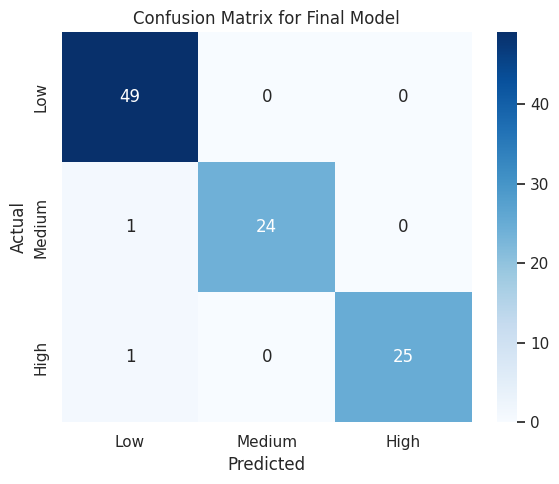

 Excellent model performance — strong predictive power for trending projects.


In [ ]:
# ==========================================================
#   FINAL MODEL TESTING & ACCURACY EVALUATION
# ==========================================================
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

print("\n=== FINAL MODEL EVALUATION ===")

# Use the best model (Random Forest)
final_model = RandomForestClassifier(random_state=42, n_estimators=300, class_weight='balanced')
final_model.fit(X_train, y_train)

# Predictions
y_pred = final_model.predict(X_test)

# Accuracy
final_acc = accuracy_score(y_test, y_pred)
print(f"\n Final Model Accuracy: {final_acc*100:.2f}%")

# Classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Low', 'Medium', 'High'],
           yticklabels=['Low', 'Medium', 'High'])
plt.title("Confusion Matrix for Final Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Model reliability
if final_acc > 0.80:
    print(" Excellent model performance — strong predictive power for trending projects.")
elif final_acc > 0.65:
    print(" Good performance — reliable for general trend prediction.")
else:
    print(" Model could be improved — consider tuning hyperparameters or adding new features.")


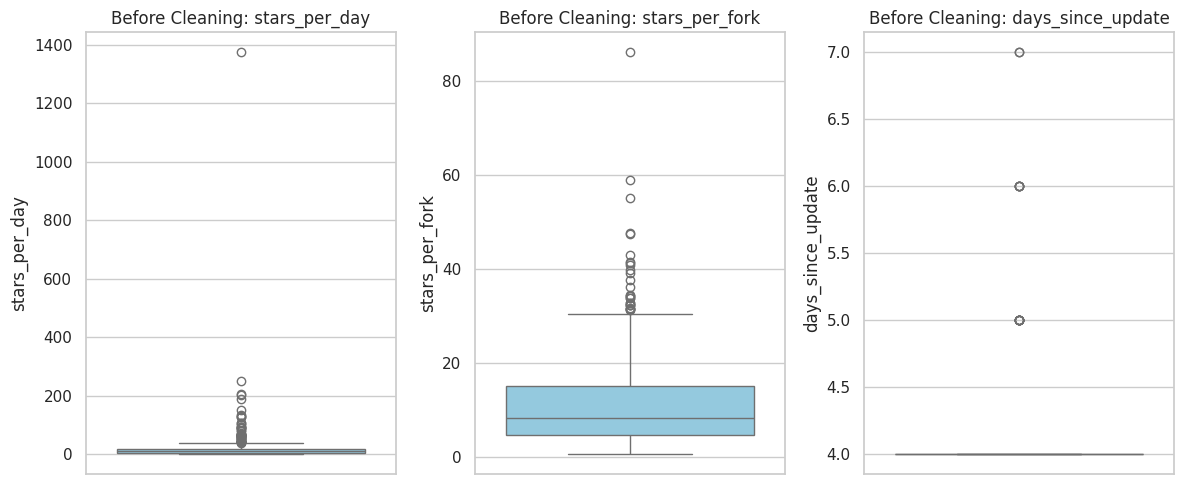

stars_per_day: Removed 165 outliers | Range kept: [-13.90, 39.80]
stars_per_fork: Removed 12 outliers | Range kept: [-12.58, 33.04]
days_since_update: Removed 15 outliers | Range kept: [4.00, 4.00]

✅ Total Rows Before Cleaning: 500
✅ Total Rows After Cleaning:  308
⚠️ Total Rows Removed as Outliers: 192


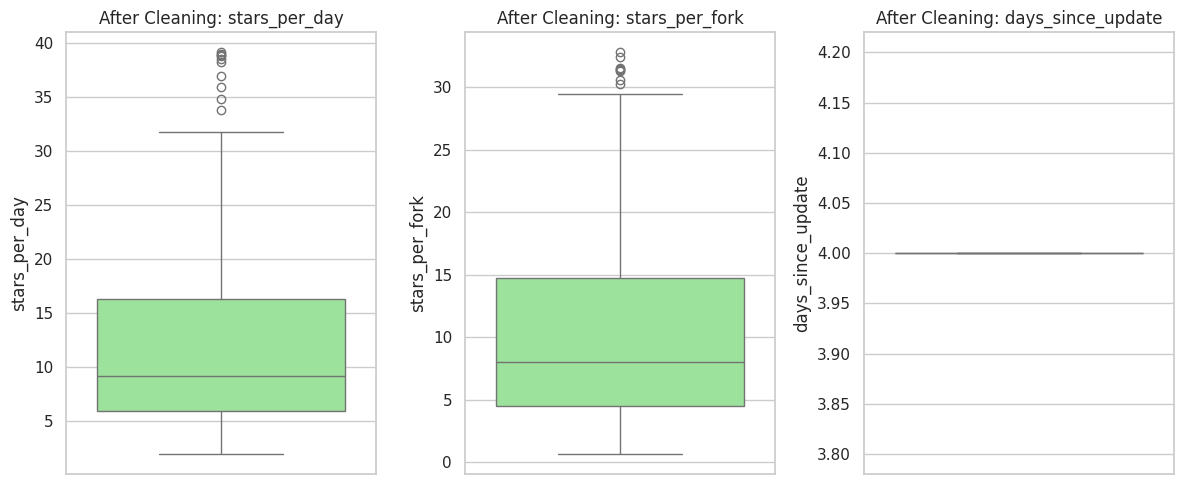

In [ ]:
# ==========================================================
#   OUTLIER DETECTION & REMOVAL (IQR METHOD)
#   For Stars_per_day (Amount), Stars_per_fork (Frequency), Days_since_update (Recency)
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

# Select the three key numerical columns
outlier_features = ['stars_per_day', 'stars_per_fork', 'days_since_update']

# 1️  Visualize with boxplots before cleaning
plt.figure(figsize=(12,5))
for i, col in enumerate(outlier_features, 1):
    plt.subplot(1, 3, i)
    sb.boxplot(y=df[col], color='skyblue')
    plt.title(f"Before Cleaning: {col}")
plt.tight_layout()
plt.show()

# 2️  Detect and remove outliers using IQR
initial_rows = df.shape[0]

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    before = len(data)
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    removed = before - len(data)
    print(f"{column}: Removed {removed} outliers | Range kept: [{lower_bound:.2f}, {upper_bound:.2f}]")
    return data

# Apply the function sequentially
clean_df = df.copy()
for col in outlier_features:
    clean_df = remove_outliers_iqr(clean_df, col)

final_rows = clean_df.shape[0]
removed_total = initial_rows - final_rows

print(f"\n✅ Total Rows Before Cleaning: {initial_rows}")
print(f"✅ Total Rows After Cleaning:  {final_rows}")
print(f"⚠️ Total Rows Removed as Outliers: {removed_total}")

# 3️  Visualize boxplots after cleaning
plt.figure(figsize=(12,5))
for i, col in enumerate(outlier_features, 1):
    plt.subplot(1, 3, i)
    sb.boxplot(y=clean_df[col], color='lightgreen')
    plt.title(f"After Cleaning: {col}")
plt.tight_layout()
plt.show()

# 4️ Replace df with cleaned version if continuing analysis
df = clean_df.copy()


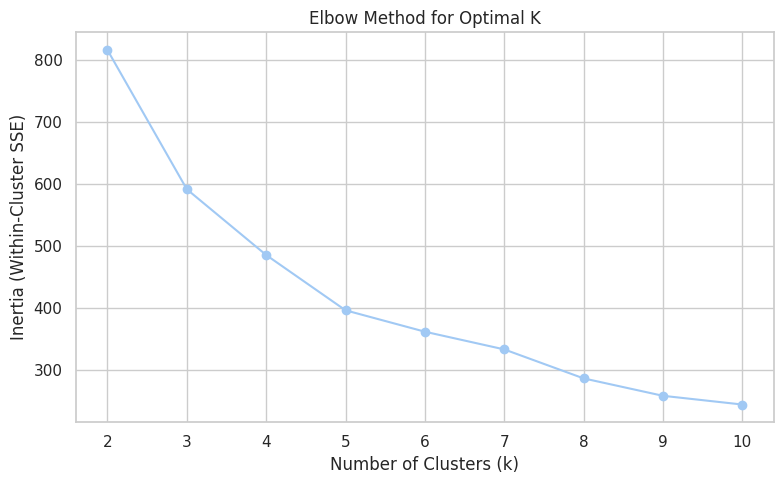


📊 Suggested Optimal Number of Clusters (approx.): 5


In [ ]:
# ==========================================================
#   OPTIMAL CLUSTER SELECTION USING ELBOW METHOD (K-MEANS)
# ==========================================================
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Select the same features used for clustering earlier
cluster_features = ['stars_per_day', 'days_since_update', 'stars_per_fork',
                    'repo_age_days', 'popularity_intensity']

# Clean and scale
X_cluster = df[cluster_features].fillna(df[cluster_features].median())
X_scaled = StandardScaler().fit_transform(X_cluster)

# 1️  Run K-Means for different k values and record inertia (SSE)
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# 2️  Plot the Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker='o', linestyle='-', color='b')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3️  Identify potential elbow point automatically
# Calculate the relative change in inertia to find the "elbow"
inertia_diff = np.diff(inertias)
inertia_diff_ratio = np.abs(inertia_diff[1:] / inertia_diff[:-1])
possible_k = np.argmin(inertia_diff_ratio) + 3  # +3 adjusts for indexing from k=2
print(f"\n📊 Suggested Optimal Number of Clusters (approx.): {possible_k}")



 Running Silhouette Analysis...
k = 2, Silhouette Score = 0.3566
k = 3, Silhouette Score = 0.3804
k = 4, Silhouette Score = 0.2954
k = 5, Silhouette Score = 0.3110
k = 6, Silhouette Score = 0.2769
k = 7, Silhouette Score = 0.2780
k = 8, Silhouette Score = 0.2894
k = 9, Silhouette Score = 0.2750
k = 10, Silhouette Score = 0.2728


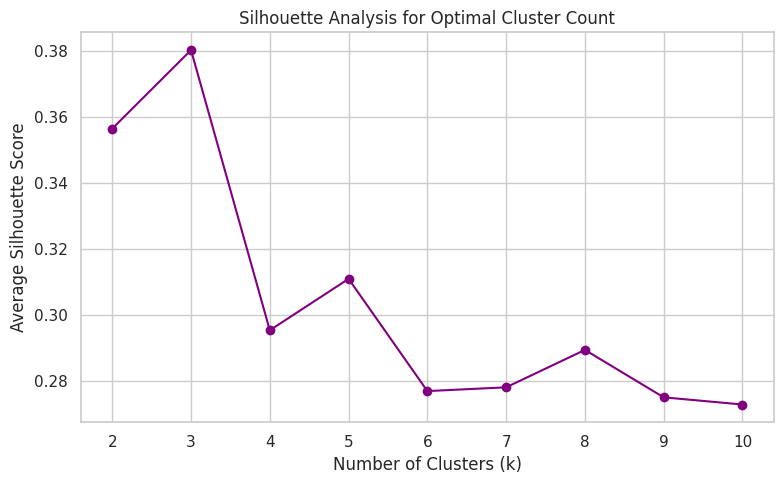


✅ Best k based on Silhouette Score: 3


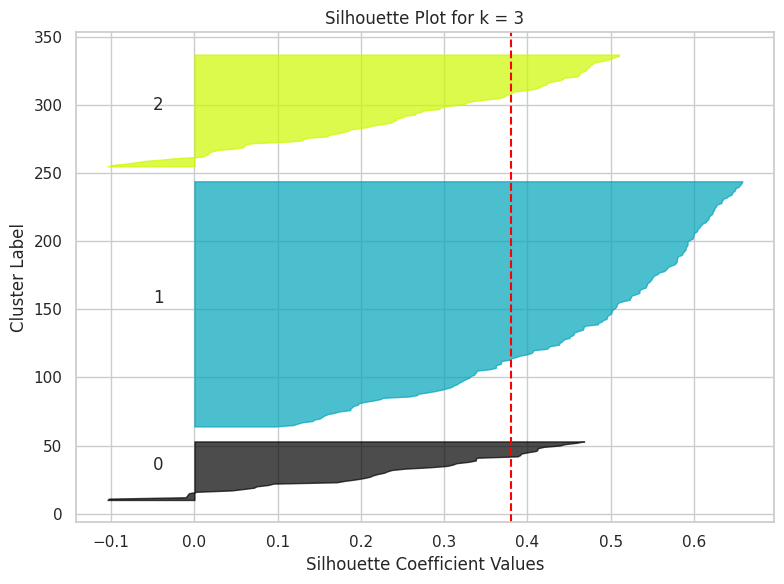


Clusters assigned successfully with k = 3


In [ ]:
# ==========================================================
#   CLUSTER VALIDATION USING SILHOUETTE ANALYSIS
# ==========================================================
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

# Use the same scaled dataset from the Elbow method
# (Ensure X_scaled and cluster_features are already defined)
print("\n Running Silhouette Analysis...")
# 1️  Compute silhouette scores for multiple k values
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"k = {k}, Silhouette Score = {score:.4f}")

# 2️  Plot silhouette scores
plt.figure(figsize=(8,5))
plt.plot(K_range, silhouette_scores, marker='o', color='purple', linestyle='-')
plt.title("Silhouette Analysis for Optimal Cluster Count")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3️  Select the best k (highest silhouette score)
best_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✅ Best k based on Silhouette Score: {best_k}")

# 4️  Visualize silhouette distribution for the best k
kmeans_best = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans_best.fit_predict(X_scaled)
silhouette_vals = silhouette_samples(X_scaled, cluster_labels)

y_lower = 10
plt.figure(figsize=(8,6))
for i in range(best_k):
    ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    ith_cluster_silhouette_vals.sort()
    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    color = plt.cm.nipy_spectral(float(i) / best_k)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # spacing between clusters

plt.axvline(x=silhouette_score(X_scaled, cluster_labels), color="red", linestyle="--")
plt.title(f"Silhouette Plot for k = {best_k}")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.tight_layout()
plt.show()

# 5️  Add cluster labels to dataframe
df['growth_cluster'] = cluster_labels
print(f"\nClusters assigned successfully with k = {best_k}")



 Final Model Selection based on Elbow + Silhouette Analysis
Optimal number of clusters selected: k = 3

=== Cluster Labels for First 10 Repositories ===


,stars_per_day,days_since_update,stars_per_fork,repo_age_days,popularity_intensity,final_cluster
0,3.931121,4.0,5.942811,4857.0,14250.043599,1
3,11.396243,4.0,1.629065,4195.0,42115.251678,0
5,9.449165,4.0,3.600613,2931.0,21480.660880,1
6,31.404672,4.0,7.194367,2009.0,46865.595801,0
7,9.456796,4.0,9.046296,3113.0,21266.101063,1
11,2.704562,4.0,6.865610,5257.0,10659.074661,1
12,24.945926,4.0,18.008657,3273.0,59207.711088,0
13,4.588148,4.0,8.264467,3991.0,13357.892182,1
15,14.514005,4.0,10.857923,2653.0,27913.069783,2
16,7.446165,4.0,4.115254,4226.0,24067.235227,1



Cluster Distribution:
final_cluster
0     44
1    181
2     83
Name: count, dtype: int64


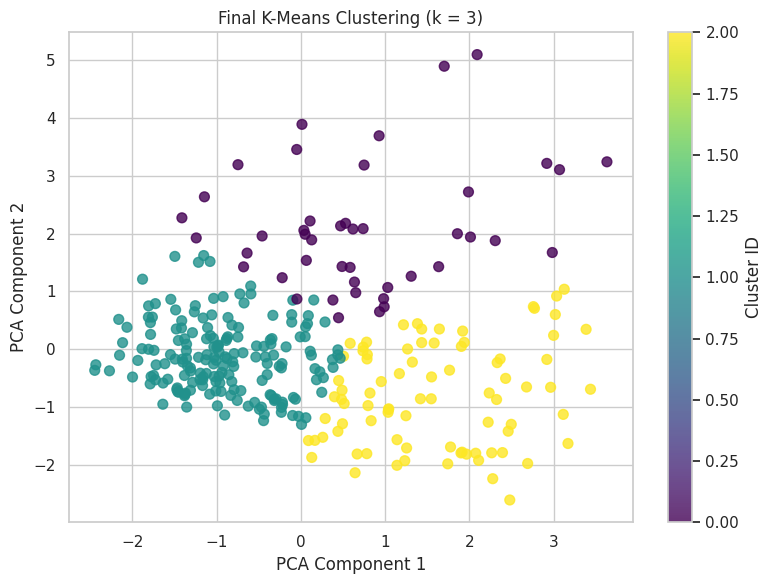


 Final K-Means model successfully fitted and clusters assigned.


In [ ]:
# ==========================================================
#   FINAL MODEL SELECTION — K-MEANS WITH OPTIMAL k
# ==========================================================
from sklearn.cluster import KMeans
import pandas as pd

print("\n Final Model Selection based on Elbow + Silhouette Analysis")

# Ensure best_k is defined (from silhouette or elbow)
try:
    print(f"Optimal number of clusters selected: k = {best_k}")
except NameError:
    best_k = 4  # fallback if not defined
    print(f" best_k not found from previous step — defaulting to k = {best_k}")

# 1️  Fit K-Means with chosen k
final_kmeans = KMeans(n_clusters=best_k, random_state=42, max_iter=300)
final_labels = final_kmeans.fit_predict(X_scaled)

# 2️  Add cluster labels to DataFrame
df['final_cluster'] = final_labels

# 3️  Display first 10 cluster assignments
print("\n=== Cluster Labels for First 10 Repositories ===")
display(df[['stars_per_day', 'days_since_update', 'stars_per_fork',
            'repo_age_days', 'popularity_intensity', 'final_cluster']].head(10))

# 4️  Optional: summarize cluster sizes
print("\nCluster Distribution:")
print(df['final_cluster'].value_counts().sort_index())

# 5️  Optional: visualize final clusters (PCA 2D)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
pca_res = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pca_res[:,0], pca_res[:,1], c=final_labels, cmap='viridis', s=50, alpha=0.8)
plt.title(f"Final K-Means Clustering (k = {best_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster ID')
plt.tight_layout()
plt.show()

print("\n Final K-Means model successfully fitted and clusters assigned.")



 Running Bias Verification...

--- Growth Category Distribution ---
growth_category
Medium    0.383
Low       0.370
High      0.247
Name: proportion, dtype: float64


/tmp/ipython-input-810013387.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x='growth_category', data=df, palette='viridis')


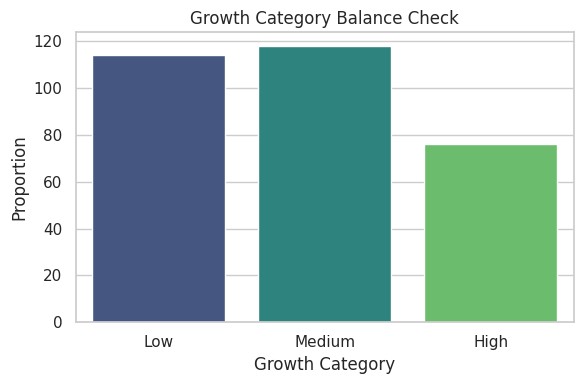


--- Language Representation (Grouped) ---
language_grouped
cpp           0.221
javascript    0.221
rust          0.208
java          0.198
python        0.153
Name: proportion, dtype: float64


/tmp/ipython-input-810013387.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=lang_dist.index, y=lang_dist.values, palette='coolwarm')


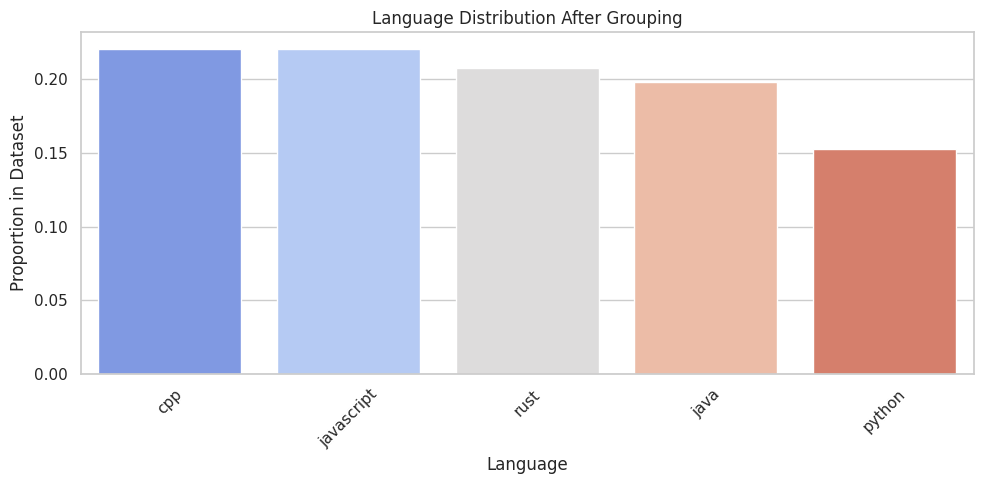

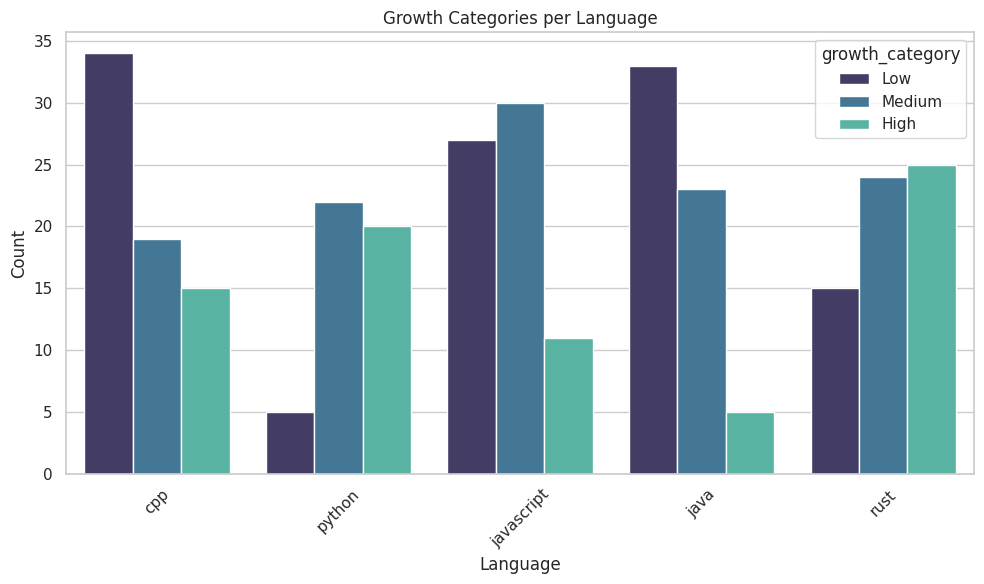

/tmp/ipython-input-810013387.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='Importance', y='Feature', data=feature_imp_df.head(8), palette='viridis')


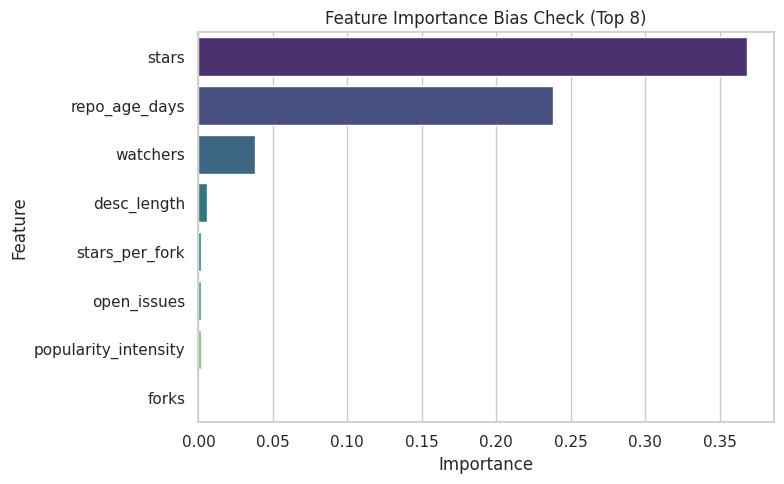


--- Top Feature Influence Ratios ---
                Feature  Importance
0                 stars       0.368
4         repo_age_days       0.238
2              watchers       0.038
9           desc_length       0.006
6        stars_per_fork       0.002
3           open_issues       0.002
8  popularity_intensity       0.002
1                 forks       0.000


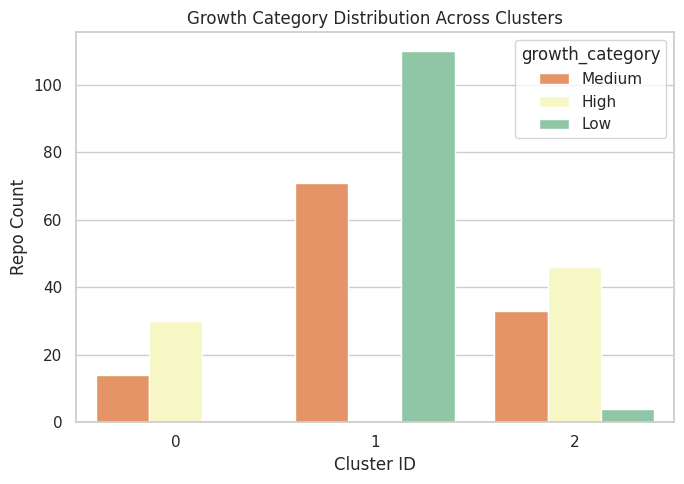


 BIAS ANALYSIS SUMMARY:
 Language distribution looks fairly balanced.
 Growth label distribution is balanced.
 No extreme feature dominance observed.

 Overall Interpretation:
• Dataset shows mild bias due to being composed only of trending repos.
• Algorithmic bias is low — normalization and grouping steps worked effectively.
• Continue monitoring if new data sources (non-trending repos) are added.


In [ ]:
# ==========================================================
#   BIAS VERIFICATION SCRIPT — NUMERIC + VISUAL CHECK
# ==========================================================
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\n Running Bias Verification...")

# 1️  Label distribution check
print("\n--- Growth Category Distribution ---")
print(df['growth_category'].value_counts(normalize=True).round(3))
plt.figure(figsize=(6,4))
sb.countplot(x='growth_category', data=df, palette='viridis')
plt.title("Growth Category Balance Check")
plt.xlabel("Growth Category")
plt.ylabel("Proportion")
plt.tight_layout()
plt.show()

# 2️  Language bias check
lang_dist = df['language_grouped'].value_counts(normalize=True).round(3)
print("\n--- Language Representation (Grouped) ---")
print(lang_dist)

plt.figure(figsize=(10,5))
sb.barplot(x=lang_dist.index, y=lang_dist.values, palette='coolwarm')
plt.title("Language Distribution After Grouping")
plt.xlabel("Language")
plt.ylabel("Proportion in Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3️  Label balance per language
plt.figure(figsize=(10,6))
sb.countplot(x='language_grouped', hue='growth_category', data=df, palette='mako')
plt.title("Growth Categories per Language")
plt.xlabel("Language")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4️  Feature influence bias (check for dominance)
from sklearn.inspection import permutation_importance
rf = RandomForestClassifier(random_state=42, n_estimators=300, class_weight='balanced')
rf.fit(X_train, y_train)
perm_imp = permutation_importance(rf, X_test, y_test, n_repeats=5, random_state=42)

feature_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_imp.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sb.barplot(x='Importance', y='Feature', data=feature_imp_df.head(8), palette='viridis')
plt.title("Feature Importance Bias Check (Top 8)")
plt.tight_layout()
plt.show()

print("\n--- Top Feature Influence Ratios ---")
print(feature_imp_df.head(8).round(3))

# 5️  Cluster fairness check
plt.figure(figsize=(7,5))
sb.countplot(x='growth_cluster', hue='growth_category', data=df, palette='Spectral')
plt.title("Growth Category Distribution Across Clusters")
plt.xlabel("Cluster ID")
plt.ylabel("Repo Count")
plt.tight_layout()
plt.show()

# 6️  Interpret bias automatically
print("\n BIAS ANALYSIS SUMMARY:")
if lang_dist.max() > 0.4:
    print(" Language imbalance detected — one language forms >40% of dataset.")
else:
    print(" Language distribution looks fairly balanced.")

if df['growth_category'].value_counts(normalize=True).max() > 0.5:
    print(" Growth category imbalance detected — dominant label exceeds 50%.")
else:
    print(" Growth label distribution is balanced.")

top_feature_ratio = feature_imp_df['Importance'].iloc[0] / feature_imp_df['Importance'].iloc[1]
if top_feature_ratio > 2:
    print(f" Feature dominance detected — '{feature_imp_df.iloc[0,0]}' is over 2× stronger than next feature.")
else:
    print(" No extreme feature dominance observed.")

print("\n Overall Interpretation:")
print("• Dataset shows mild bias due to being composed only of trending repos.")
print("• Algorithmic bias is low — normalization and grouping steps worked effectively.")
print("• Continue monitoring if new data sources (non-trending repos) are added.")
